# 6.2 Evaluating Classification Models

There is an old joke that "economists have predicted 9 of the last 5 recessions." In some sense, this is a commentary on the difficulty of evaluating predictive models. Even if economists predicted all 5 recessions that did happen, they should be penalized for predicting an additional 4 recessions that did not happen. In this section, we will develop the vocabulary to critique predictive models, such as the one mentioned in the joke.

In [ ]:
import pandas as pd

data_dir = "http://dlsun.github.io/pods/data/"
df_breast = pd.read_csv(data_dir + "breast-cancer.csv")
df_breast.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


How do we measure how good a classification model is? Perhaps the most obvious metric is _accuracy_, which simply measures how often the predicted label matches the actual label. (Remember that the label in a classification model is a _categorical variable_.) Let's train a $10$-nearest neighbors model on the breast cancer data, just so that we have a model to evaluate.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train = df_breast[["Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape",
                     "Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei",
                     "Bland Chromatin", "Normal Nucleoli", "Mitoses"]]
y_train = df_breast["Class"]

model = KNeighborsClassifier(n_neighbors=10)
model.fit(X=X_train, y=y_train)

KNeighborsClassifier(n_neighbors=10)

Now, we calculate the model's predictions on the training data, and calculate how often the prediction matches the ground truth.

In [ ]:
y_train_ = model.predict(X_train)
accuracy = (y_train_ == y_train).mean()
accuracy

0.9736456808199122

There is also a scikit-learn function that calculates the accuracy.

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_train_)

0.9736456808199122

The accuracy is 97.4%, which sounds impressive. But it would be less impressive if 97.4% of all samples in the data were benign, since the same accuracy could be achieved by a useless model that predicts that every sample is benign.

The problem with a model that predicts that every sample is benign is that, although the model might be accurate overall, it is very inaccurate for malignant samples. We want a model that is not just accurate overall, but accurate for both benign and malignant samples. There is some ambiguity in how to define "accuracy for malignant samples". As a result, there are two metrics: _precision_ and _recall_.

## Precision and Recall

Suppose we want to calculate the "accuracy" of our model for class $c$. There are two ways to interpret "accuracy for class $c$". Do we want to know the accuracy among the observations our model _predicted to be_ in class $c$ or the accuracy among the observations that _actually were_ in class $c$? The two options lead to two different notions of "accuracy" for class $c$: precision and recall.

The **precision** of a model for class $c$ is the proportion of observations predicted to be in class $c$ that actually were in class $c$. 

$$ \textrm{precision for class } c = \frac{\text{number of observations in class $c$ that were predicted to be in $c$}}{\text{number of observations predicted to be in class $c$}}. $$

The **recall** of a model for class $c$ is the proportion of observations actually in class $c$ that were predicted to be in class $c$.

$$ \textrm{recall for class } c = \frac{\text{number of observations in class $c$ that were predicted to be in $c$}}{\text{number of observations in class $c$}}. $$

Another way to think about precision and recall is in terms of true positives (TP) and false positives (FP). A "positive" is an observation that the model identified as belonging to class $c$. A true positive is one that actually was in class $c$ (i.e., $\hat y = c$ and $y = c$), while a false positive is one that was not (i.e., $\hat y = c$ and $y \neq c$). True and false negatives are defined analogously.

In the language of positives and negatives, the precision is the proportion of positives that are true positives:
$$ \textrm{precision for class } c = \frac{TP}{TP + FP}, $$
while the recall is the proportion of observations in class $c$ that are positives (as opposed to negatives):
$$ \textrm{recall for class } c = \frac{TP}{TP + FN}. $$

The figure below may help you to remember which numbers go in the numerator and denominator. The precision is the proportion of the red rectangle that TP makes up, while the recall is the proportion of the red circle that TP makes up.

![](https://github.com/dlsun/pods/blob/master/06-Classification-Models/precision_recall.png?raw=1)

Let's calculate the precision and recall of our $10$-nearest neighbors model for benign masses.

In [ ]:
true_positives = ((y_train_ == 0) & (y_train == 0)).sum()

precision = true_positives / (y_train_ == 0).sum()
recall = true_positives / (y_train == 0).sum()
    
precision, recall

(0.9775784753363229, 0.9819819819819819)

You can also have scikit-learn calculate the precision and recall. These functions work similarly to `accuracy_score` above, except we have to explicitly specify the class for which we want the precision and recall. For example, to calculate the precision and recall for benign masses:

In [ ]:
from sklearn.metrics import precision_score, recall_score

(precision_score(y_train == 0, y_train_ == 0),
 recall_score(y_train == 0, y_train_ == 0))

(0.9775784753363229, 0.9819819819819819)

It is important to specify the class explicitly when calculating the precision and recall. Each class has a different precision and recall. For example, the precision and recall for malignant masses is lower.

In [ ]:
(precision_score(y_train == 1, y_train_ == 1),
 recall_score(y_train == 1, y_train_ == 1))

(0.9662447257383966, 0.9581589958158996)

## Precision-Recall Curves

In general, there is a tradeoff between precision and recall. For example, you can improve recall by casting a wider net, predicting more observations to be in class $c$, but this will hurt precision in general. To take an extreme example, a model that predicts that _every_ observation is in class $c$ necessarily has 100% recall, but its precision will likely be poor. To visualize this phenomenon, suppose we expand the positives from the dashed circle to the solid circle, as shown in the figure below, at right. This increases recall (because the circle now covers more of the red rectangle) but decreases precision (because the red rectangle now makes up a smaller fraction of the circle).

![](https://github.com/dlsun/pods/blob/master/06-Classification-Models/precision_recall_tradeoff.png?raw=1)

Likewise, we can improve precision by predicting fewer observations to be in class $c$ (i.e., only the ones you are very confident about), but this will hurt recall. This is illustrated in the figure above, at left.

How do we cast a wider (or narrower) net? In many classification models, the predicted label is obtained by first obtaining the predicted probabilities and then choosing the class with the highest probability. 

In the case of the breast cancer data set, there are only two classes, so we predict that a breast mass is malignant if the predicted probability of malignancy is $0.5$ or higher. (We predict it is benign otherwise). Instead of using $0.5$ as the threshold, we could cast a wider net for malignancy by lowering the threshold to $0.4$, predicting a breast mass to be malignant as long as the predicted probability is $0.4$ or higher.

In [ ]:
probas_ = model.predict_proba(X_train)
probas_

array([[1. , 0. ],
       [0.1, 0.9],
       [1. , 0. ],
       ...,
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ]])

In [ ]:
y_train_ = (probas_[:, 1] >= 0.4)

(precision_score(y_train == 1, y_train_ == 1),
 recall_score(y_train == 1, y_train_ == 1))

(0.948, 0.9916317991631799)

We see that recall increases to 99.2% when we cast this wider net, at the expense of precision, which drops to 94.8%.

It is often instructive to calculate the precision and recall for all possible thresholds and then graph the values as a _precision-recall curve_. Scikit-learn provides a function to calculate the precision and recall for different 

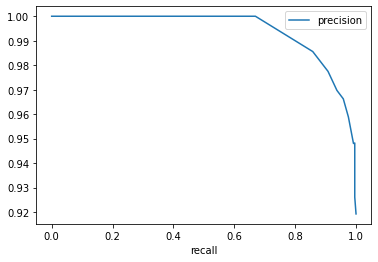

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(
    y_train == 1, probas_[:, 1]
)

pd.DataFrame({
    "precision": precisions,
    "recall": recalls
}).plot.line(x="recall", y="precision")

This curve makes the tradeoff between precision and recall explicit. As we lower the threshold, the recall for malignant masses increases from 0% to 100%, while the precision decreases from 100% to about 92%.

We can also plot the precision-recall curve for benign masses.

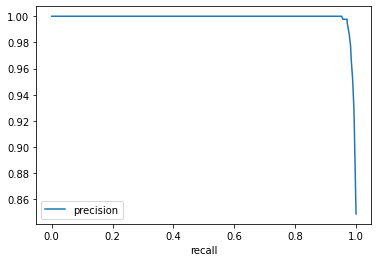

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(
    y_train == 0, probas_[:, 0]
)

pd.DataFrame({
    "precision": precisions,
    "recall": recalls
}).plot.line(x="recall", y="precision")

## F1 Score: Combining Precision and Recall

We have replaced accuracy by two numbers: precision and recall. We can combine the precision and recall into a single number, called the **F1 score**. 

The F1 score is defined to be the **harmonic mean** of the precision and the recall. That is, 

$$ \frac{1}{\text{F1 score}} = \frac{ \frac{1}{\text{precision}} + \frac{1}{\text{recall}}}{2}, $$

or equivalently, 

$$ \text{F1 score} = \frac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}. $$

The harmonic mean of two numbers is always between the two numbers, but in general will be closer to the smaller number. For example, if precision is $90\%$ and recall is $10\%$, then the harmonic mean is 

$$ \text{F1 score} = \frac{2 \cdot 0.9 \cdot 0.1}{0.9 + 0.1} = 18\%. $$

This is a desirable property of F1 scores because we want to encourage models to have both high precision _and_ high recall. It is not sufficient for one of these to be high if the other is very low. In other words, we do not want a high precision to compensate for a low recall, or vice versa.

The F1 score for benign masses is:

In [ ]:
2 * precision * recall / (precision + recall)

0.9797752808988766

We could have also asked Scikit-Learn calculate this for us. If we know the actual and predicted labels, we can use the `f1_score` function, which works similarly to `precision_score` and `recall_score` from above:

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train == 0, y_train_ == 0)

0.9828962371721778

# Exercises

Exercises 1-2 ask you to use the Titanic data set (`https://dlsun.github.io/pods/data/titanic.csv`) to train various classifiers.

In [ ]:
titanic = pd.read_csv("https://dlsun.github.io/pods/data/titanic.csv")
titanic.head()

,name,gender,age,class,embarked,country,ticketno,fare,survived
0,"Abbing, Mr. Anthony",male,42.0,3rd,S,United States,5547.0,7.11,0
1,"Abbott, Mr. Eugene Joseph",male,13.0,3rd,S,United States,2673.0,20.05,0
2,"Abbott, Mr. Rossmore Edward",male,16.0,3rd,S,United States,2673.0,20.05,0
3,"Abbott, Mrs. Rhoda Mary 'Rosa'",female,39.0,3rd,S,England,2673.0,20.05,1
4,"Abelseth, Miss. Karen Marie",female,16.0,3rd,S,Norway,348125.0,7.13,1


In [ ]:
titanic = titanic[~titanic["age"].isna()]

1\. Train a 5-nearest neighbors model to predict whether or not a passenger on a Titanic survived, using their age, sex, and class as features. Calculate the accuracy, precision, and recall of this model (on the training data) for the survivors and the deceased.

In [ ]:
X_train = titanic[["age", "gender", "class"]]
y_train = titanic["survived"]

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

ct = make_column_transformer(
    (OneHotEncoder(), ["gender", "class"]),
    (StandardScaler(), ["age"]),
    remainder="drop"
)

pipeline = make_pipeline(
    ct,
    KNeighborsClassifier(n_neighbors=5)
).fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_pred = pipeline.predict(X_train)
accuracy_score(y_train==1, y_pred==1), precision_score(y_train==1, y_pred==1), recall_score(y_train==1, y_pred==1)

(0.8263038548752835, 0.8166023166023166, 0.5949367088607594)

2\. Plot the precision-recall curve for the survivors.

In [ ]:
from sklearn.metrics import precision_recall_curve
y_pred = pipeline.predict_proba(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train==1, y_pred[:,1])

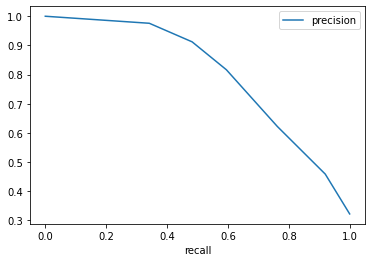

In [ ]:
pd.DataFrame({
    "precision": precisions,
    "recall": recalls
}).plot.line(x="recall", y="precision")